In [1]:
import numpy as np
import astropy
from astropy.io import fits
from matplotlib import pyplot
import pandas as pd
import os

import auxil_ML as aux
import plotting as my_plot

In [251]:
cat = '3FGL'
folder = '../ML_3FGL_paper/SOM'
cat_fn = '%s/%s_prob_catalog.csv' % (folder, cat)
cat_df = pd.read_csv(cat_fn, index_col=0)

#cat = '4FGL' # '3FGL', '4FGL'
if cat == '3FGL':
    fn_cat = '../PS_comparison/gll_psc_v16.fit' # the last release of 3FGL
else:
    fn_cat = '../PS_comparison/gll_psc_v22.fit' # 4FGL release from 27 May 2020
    #fn_cat = '../PS_comparison/gll_psc_v26.fit' # 4FGL_DR2
hdu_cat = fits.open(fn_cat)
fgl_df = aux.hdu2df(hdu_cat[1], index_name='Source_Name') # transform hdu table to dataframe
fgl_df = fgl_df.loc[cat_df.index] # remove sources with missing values - not needed for merge
fgl_df.index = fgl_df.index.set_names('Source_Name_%s' % cat) # to merge on index name
fgl_df['SpectrumType'] = [s.strip() for s in fgl_df['SpectrumType']]

E1 = 0.3 # GeV

In [252]:
fgl_df.columns

Index(['RAJ2000', 'DEJ2000', 'GLON', 'GLAT', 'Conf_68_SemiMajor',
       'Conf_68_SemiMinor', 'Conf_68_PosAng', 'Conf_95_SemiMajor',
       'Conf_95_SemiMinor', 'Conf_95_PosAng', 'ROI_num', 'Signif_Avg',
       'Pivot_Energy', 'Flux_Density', 'Unc_Flux_Density', 'Flux1000',
       'Unc_Flux1000', 'Energy_Flux100', 'Unc_Energy_Flux100', 'Signif_Curve',
       'SpectrumType', 'Spectral_Index', 'Unc_Spectral_Index', 'beta',
       'Unc_beta', 'Cutoff', 'Unc_Cutoff', 'Exp_Index', 'Unc_Exp_Index',
       'PowerLaw_Index', 'Flux30_100', 'Unc_Flux30_100', 'nuFnu30_100',
       'Sqrt_TS30_100', 'Flux100_300', 'nuFnu100_300', 'Sqrt_TS100_300',
       'Flux300_1000', 'nuFnu300_1000', 'Sqrt_TS300_1000', 'Flux1000_3000',
       'nuFnu1000_3000', 'Sqrt_TS1000_3000', 'Flux3000_10000',
       'nuFnu3000_10000', 'Sqrt_TS3000_10000', 'Flux10000_100000',
       'nuFnu10000_100000', 'Sqrt_TS10000_100000', 'Variability_Index',
       'Signif_Peak', 'Flux_Peak', 'Unc_Flux_Peak', 'Time_Peak',
       'Peak_I

In [253]:
# calculate index at 500 MeV
if cat == '3FGL':
    n500_array = np.array(fgl_df['Spectral_Index'])
    E0 = fgl_df['Pivot_Energy'] / 1000.
    Ecut = fgl_df['Cutoff'] / 1000.

    lp_mask = (fgl_df['SpectrumType'] == 'LogParabola')
    n500_array[lp_mask] = (fgl_df['Spectral_Index'] + 2*fgl_df['beta']*np.log(E1 / E0))[lp_mask]

    ec_mask = (fgl_df['SpectrumType'] == 'PLExpCutoff')
    n500_array[ec_mask] = (fgl_df['Spectral_Index'] + E1 / E0)[ec_mask]

    se_mask = (fgl_df['SpectrumType'] == 'PLSuperExpCutoff')
    n500_array[se_mask] = (fgl_df['Spectral_Index'] + fgl_df['Exp_Index'] * E1 / E0)[se_mask]

    pl_mask = (fgl_df['SpectrumType'] == 'PowerLaw')
    np.sum(lp_mask) + np.sum(ec_mask) + np.sum(se_mask) + np.sum(pl_mask)


In [254]:
if cat == '3FGL':
    pl_name = 'PowerLaw_Index'
    fgl_df_add = fgl_df[[pl_name]]
else:
    pl_name = 'PL_Index'
    fgl_df_add = fgl_df[['PLEC_Index']]


In [255]:
cat_df.columns

Index(['Ln_Flux_Density', 'Ln_Unc_Energy_Flux100', 'Spectral_Index',
       'Ln_Signif_Curve', 'Ln_Variability_Index', 'HR12', 'HR23', 'HR34',
       'HR45', 'GLAT', 'Category_3FGL', 'CLASS_3FGL', 'Pivot_Energy',
       'Spectrum_Type', 'ASSOC1', 'GLON', 'Source_Name', 'AGN_BDT_O',
       'AGN_BDT_STD_O', 'PSR_BDT_O', 'PSR_BDT_STD_O', 'AGN_NN_O',
       'AGN_NN_STD_O', 'PSR_NN_O', 'PSR_NN_STD_O', 'AGN_RF_O', 'AGN_RF_STD_O',
       'PSR_RF_O', 'PSR_RF_STD_O', 'AGN_LR_O', 'AGN_LR_STD_O', 'PSR_LR_O',
       'PSR_LR_STD_O', 'AGN_BDT', 'AGN_BDT_STD', 'PSR_BDT', 'PSR_BDT_STD',
       'AGN_NN', 'AGN_NN_STD', 'PSR_NN', 'PSR_NN_STD', 'AGN_RF', 'AGN_RF_STD',
       'PSR_RF', 'PSR_RF_STD', 'AGN_LR', 'AGN_LR_STD', 'PSR_LR', 'PSR_LR_STD',
       'Flags', 'Category_Prob'],
      dtype='object')

In [256]:
if fgl_df_add is not None:
    cat_df = cat_df.merge(fgl_df_add, on=['Source_Name_%s' % cat])

In [257]:
cat_df.columns

Index(['Ln_Flux_Density', 'Ln_Unc_Energy_Flux100', 'Spectral_Index',
       'Ln_Signif_Curve', 'Ln_Variability_Index', 'HR12', 'HR23', 'HR34',
       'HR45', 'GLAT', 'Category_3FGL', 'CLASS_3FGL', 'Pivot_Energy',
       'Spectrum_Type', 'ASSOC1', 'GLON', 'Source_Name', 'AGN_BDT_O',
       'AGN_BDT_STD_O', 'PSR_BDT_O', 'PSR_BDT_STD_O', 'AGN_NN_O',
       'AGN_NN_STD_O', 'PSR_NN_O', 'PSR_NN_STD_O', 'AGN_RF_O', 'AGN_RF_STD_O',
       'PSR_RF_O', 'PSR_RF_STD_O', 'AGN_LR_O', 'AGN_LR_STD_O', 'PSR_LR_O',
       'PSR_LR_STD_O', 'AGN_BDT', 'AGN_BDT_STD', 'PSR_BDT', 'PSR_BDT_STD',
       'AGN_NN', 'AGN_NN_STD', 'PSR_NN', 'PSR_NN_STD', 'AGN_RF', 'AGN_RF_STD',
       'PSR_RF', 'PSR_RF_STD', 'AGN_LR', 'AGN_LR_STD', 'PSR_LR', 'PSR_LR_STD',
       'Flags', 'Category_Prob', 'PowerLaw_Index'],
      dtype='object')

In [267]:
bins = np.linspace(0, 4, 40)
def plot_hist(arr, title, bins=bins, dens=1):
    pyplot.figure()
    alpha = 0.4
    mask = cat_df['Category_%s' % cat] == 'PSR'
    hst = pyplot.hist(arr[mask], bins=bins, alpha=alpha, density=dens, label='%s PSR' %cat,
                      ls='-', lw=2, edgeColor='black', histtype='stepfilled')
    if dens:
        mask = cat_df['Category_%s' % cat] == 'AGN'
        hst = pyplot.hist(arr[mask], bins=bins, alpha=alpha, density=dens, label='%s AGN' % cat,
                          ls='--', lw=2, edgeColor='black', histtype='stepfilled')
        mask = cat_df['Category_%s' % cat] == 'UNAS'
        hst = pyplot.hist(arr[mask], bins=bins, alpha=alpha, density=dens, label='%s UNAS' % cat,
                         ls='-.', lw=2, edgeColor='black', histtype='stepfilled')
    mask = (cat_df['Category_Prob'] == 'PSR') & (cat_df['Category_%s' % cat] == 'UNAS')
    hst = pyplot.hist(arr[mask], bins=bins, alpha=alpha, density=dens, label='Unas Prob PSR',
                      ls=':', lw=2, edgeColor='black', histtype='stepfilled')
    pyplot.legend(loc='best')
    if dens:
        pyplot.ylabel('density')
    else:
        pyplot.ylabel('counts')
    pyplot.xlabel('Index')
    pyplot.title('%s %s' % (cat, title))

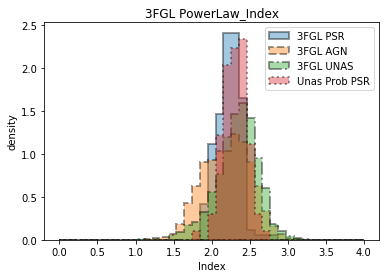

In [268]:
plot_hist(cat_df[pl_name], pl_name)
pyplot.savefig('plots/hists/%s_%s.pdf' % (pl_name, cat))

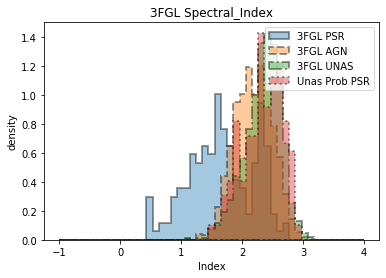

In [269]:
if cat == '3FGL':
    name = 'Spectral_Index'
else:
    name = 'PLEC_Index'
    binsl = np.linspace(-1, 4, 50)
plot_hist(cat_df[name], name, bins=binsl)
pyplot.savefig('plots/hists/%s_%s.pdf' % (name, cat))

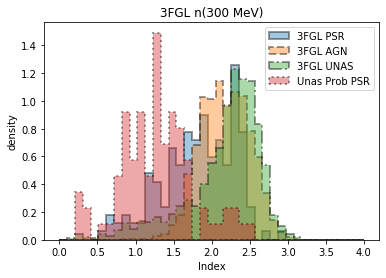

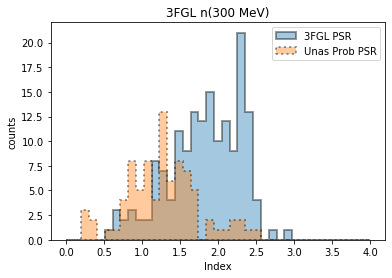

In [270]:
if cat == '3FGL':
    #bins = np.linspace(1, 4, 60)
    E1_MeV = E1 * 1000
    plot_hist(n500_array, 'n(%i MeV)' % E1_MeV, dens=1, bins=bins)
    pyplot.savefig('plots/hists/n%i_%s.pdf' % (E1_MeV, cat))

    plot_hist(n500_array, 'n(%i MeV)' % E1_MeV, dens=0, bins=bins)
    pyplot.savefig('plots/hists/n%i_%s_abs.pdf' % (E1_MeV, cat))